This compares how reproduction is determined by the DMS Selector and the three-step Selector.
Both selectors start from the $K_D$, which is determined from the $\Delta log_{10}K_D$: $K_D = 10^{(naive K_D - \Delta log_{10}K_D)}$, where a positive $\Delta log_{10}K_D$ represents an increase in affinity from naive.

The fraction of antigen bound is also determined in the same way, with it being determined by $\theta = { M_{antigen} \over {K_D + M_{antigen}}}$

The DMS selector then uses a linear or sigmoidal function (sigmoidal in this notebook, as $maxsignal \over 1+e^{-growthrate(\theta - \theta_{mid})}$) to determine the T cell help signal from these antigen bound values, then normalizes them if competition is on (which is consistently true in this notebook) via $signal \over \Sigma signals$

These values are then multiplied by a constant to produce the number of cell divisions.

The three-step Selector applies a minimum cutoff to the antigen bound in the first step (``norm1``). Then, these values (``competencies``, which are $\theta$ values after the cutoff is applied) are sigmoidally mapped to a signal between 0 and 1 (``norm2``), given by $1 \over 1+e^{-growthrate(\theta - \theta_{mid})}$. These values are then normalized: ``norm_signal``$=  {signal \over \Sigma signals}$

In ``norm3``, a discrete quantity of T cell help is distributed among cells. Each ``norm_signal`` represents a weighted probability of receiving T cell help, and cells are chosen with replacement, though prevented from receiving more than a determined maximum quantity of T cell help, until all T cell help has been distributed or every cell has the maximum T cell help. Each cell's fitness is determined by the units of T cell help it receives.

Making sample set: starting from observed sequences and KDs from replay data

In [1]:
from gcdyn.cycles import (
    ThreeStepSelector,
    simple_proliferator,
    FivemerMutator,
    UniformMutator,
    DMSSelector,
    UniformSelector,
    cell_div_balanced_proliferator,
)
from gcdyn.phenotype import DMSPhenotype
from numpy.random import default_rng
from Bio import SeqIO
from ete3 import TreeNode
from plotnine import (
    ggplot,
    aes,
    geom_histogram,
    after_stat,
    geom_density,
    xlim,
    geom_point,
)
import pandas as pd
from statistics import mean, median
from math import exp
from IPython.display import display

fasta_path = "gcreplay_samples/gctree_PR1.3-1-LB-16-GC-KD_recalc.fasta"
seqs = [str(seq_record.seq) for seq_record in SeqIO.parse(fasta_path, "fasta")]
mult_seqs = seqs * 20
KDs = [
    float(seq_record.id.split("|")[1])
    for seq_record in SeqIO.parse(fasta_path, "fasta")
]
mult_KDs = KDs * 20

In [2]:
phenotype = DMSPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "Linear.model",
    ["delta_log10_KD", "delta_expression"],
    -10.43,
)

Using ThreeStepSelector to make selections and proliferating

In [3]:
threenormselector = ThreeStepSelector(
    concentration_antigen=10 ** (-10),
    total_t_cell_help=1000,
    max_help=6,
    antigen_frac_limit=0.2,
)
fitnesses = threenormselector.select(mult_seqs, kd_list=mult_KDs)

In [4]:
fivemer_mutator = FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)
uniform_mutator = UniformMutator()

In [5]:
alive_leaves = []
tree_renders = []
for seq in mult_seqs:
    leaf = TreeNode()
    leaf.dist = 0
    leaf.sequence = seq
    alive_leaves.append(leaf)

In [6]:
descendant_seqs = []
tree_renders = []
for leaf, args in zip(alive_leaves, fitnesses):
    cell_div_balanced_proliferator(leaf, *args)
    for node in leaf.iter_descendants():
        # node.sequence = node.up.sequence
        node.sequence = fivemer_mutator.mutate(node.up.sequence, node.dist)
        if node.is_leaf() and node != leaf:
            descendant_seqs.append(node.sequence)
    # tree_renders.append(leaf.render("%%inline", w=200))
# for render in tree_renders:
#   display(render)

In [7]:
print(f"number of descendants: {len(descendant_seqs)}")
num_expected_descendants = 0
for fitness in fitnesses:
    if fitness[0] > 0:
        num_expected_descendants += 2 ** fitness[0]
print(f"expected number of descendants: {num_expected_descendants}")

number of descendants: 2344
expected number of descendants: 2344.0


In [8]:
descendant_KDs = phenotype.calculate_KD(descendant_seqs)

In [9]:
fit_sum = 0
for fitness in fitnesses:
    fit_sum += fitness[0]
print(f"sum of fitnesses: {fit_sum}")

sum of fitnesses: 1000.0


Naive KD: 3.7153522909717275e-11
Original KDs: mean 5.817783359026082e-10, median 5.367487565772558e-12, minimum 2.2684547652542707e-13, maximum 1.5923808200515968e-08, range 1.592358135503944e-08, count 1160
Descendant KDs: mean 7.6366539116432e-10, median 4.535769391037438e-12, minimum 1.388522493021946e-13, maximum 1.2652198711194917e-06, range 1.2652197322672425e-06, count 2344


/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 150 rows containing non-finite values.


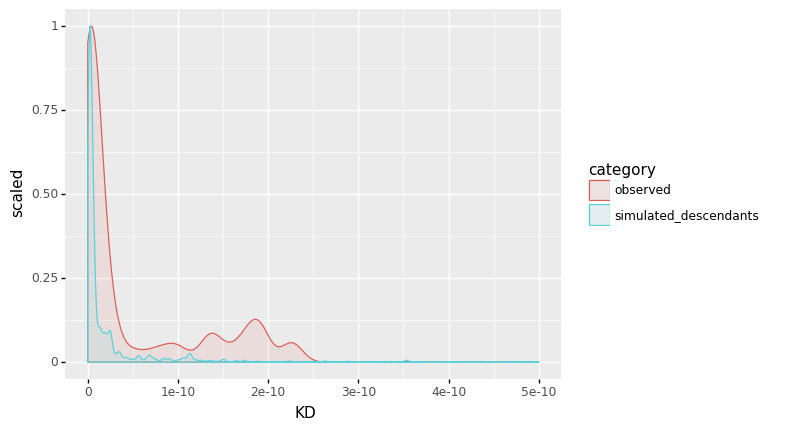

<ggplot: (8782663974870)>

In [10]:
cats = ["observed"] * len(mult_KDs)
cats.extend(["simulated_descendants"] * len(descendant_KDs))
all_KDs = mult_KDs + descendant_KDs
KD_df = pd.DataFrame({"KD": all_KDs, "category": cats})

print(f"Naive KD: {10 ** (-10.43)}")
print(
    f"Original KDs: mean {mean(mult_KDs)}, median {median(mult_KDs)}, minimum {min(mult_KDs)}, maximum {max(mult_KDs)}, range {max(mult_KDs) - min(mult_KDs)}, count {len(mult_KDs)}"
)
print(
    f"Descendant KDs: mean { mean(descendant_KDs)}, median {median(descendant_KDs)}, minimum {min(descendant_KDs)}, maximum {max(descendant_KDs)}, range {max(descendant_KDs) - min(descendant_KDs)}, count {len(descendant_KDs)}"
)
(
    ggplot(KD_df, aes(x="KD", color="category", fill="category"))
    + geom_density(aes(y=after_stat("scaled")), alpha=0.1)
    + xlim(0, 0.5 * 10 ** (-9))
)

Distributions of signal in descendants:

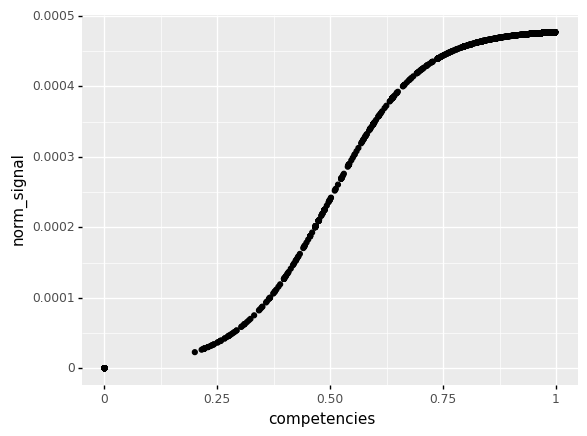

<ggplot: (8782663971672)>

In [11]:
competencies = threenormselector.norm1(descendant_KDs)
midpoint_competency = 0.5
curve_steepness = 10
unnorm_signals = []
from math import exp

for competency in competencies:
    if competency == 0:
        unnorm_signals.append(0)
    else:
        unnorm_signals.append(
            1 / (1 + exp(-1 * curve_steepness * (competency - midpoint_competency)))
        )
competencies_df = pd.DataFrame(
    {
        "competency": competencies,
        "KD": descendant_KDs,
        "norm_signal": threenormselector.norm2_sigmoid(
            competencies,
            midpoint_competency=midpoint_competency,
            curve_steepness=curve_steepness,
        ),
        "unnorm_signal": unnorm_signals,
    }
)


(ggplot(competencies_df) + aes(x="competencies", y="norm_signal") + geom_point())

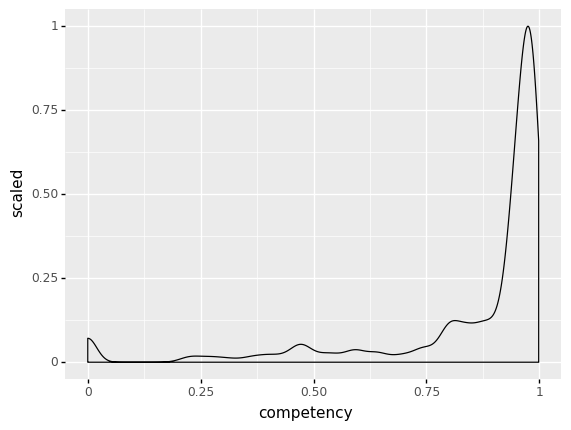

<ggplot: (8782634374515)>

In [12]:
(
    ggplot(competencies_df, aes(x="competency"))
    + geom_density(aes(y=after_stat("scaled")), alpha=0.1)
)

Relationship between KD and antigen bound

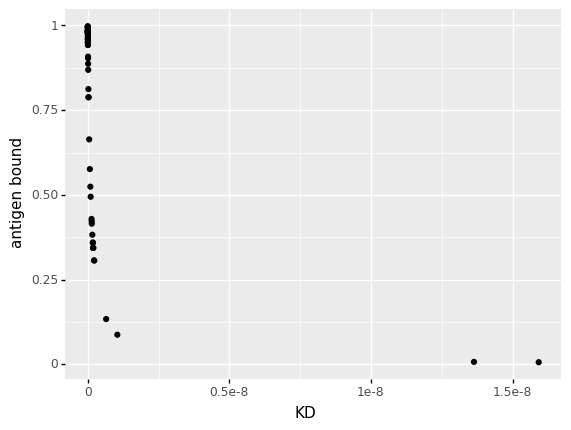

<ggplot: (8782636090618)>

In [13]:
no_frac_limit_selector = ThreeStepSelector(
    concentration_antigen=10 ** (-10),
    total_t_cell_help=1000,
    max_help=6,
    antigen_frac_limit=0,
)
antigen_bound_vals = no_frac_limit_selector.norm1(KDs)

antigen_bound_KD_df = pd.DataFrame({"antigen bound": antigen_bound_vals, "KD": KDs})

(ggplot(antigen_bound_KD_df) + aes(x="KD", y="antigen bound") + geom_point())

DMS selector comparison

In [14]:
from numpy.random import default_rng

dms_alive_leaves = []
dms_selector = DMSSelector(slope=1000, y_intercept=0)
dms_fitnesses = dms_selector.select(mult_seqs)

for seq in mult_seqs:
    leaf = TreeNode()
    leaf.sequence = seq
    dms_alive_leaves.append(leaf)

dms_descendant_seqs = []
for leaf, args in zip(dms_alive_leaves, dms_fitnesses):
    cell_div_balanced_proliferator(leaf, *args)
    for node in leaf.iter_descendants():
        node.sequence = node.up.sequence
        node.sequence = fivemer_mutator.mutate(node.up.sequence, node.dist)
        for desc in node.iter_leaves():
            dms_descendant_seqs.append(node.sequence)
dms_descendant_KDs = phenotype.calculate_KD(dms_descendant_seqs)
print(len(dms_descendant_KDs))

3500


Naive KD: 3.7153522909717275e-11
Original KDs: mean 5.817783359026082e-10, median 5.367487565772558e-12
Descendant KDs: mean 5.355267066062627e-08, median 5.360077936159021e-12


/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 221 rows containing non-finite values.


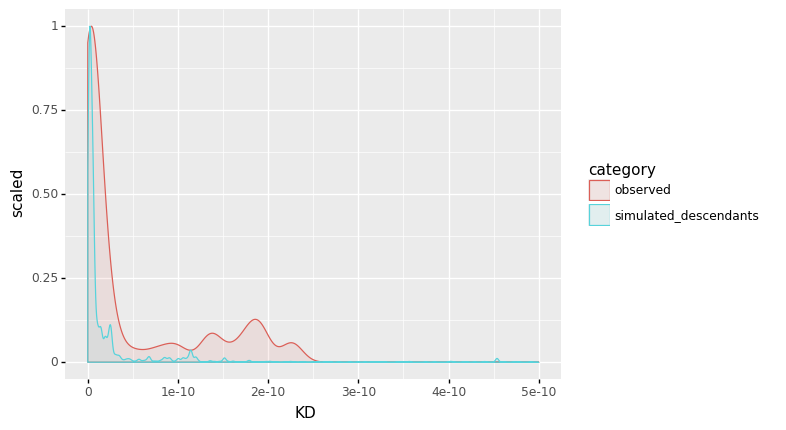

<ggplot: (8782633156807)>

In [15]:
cats = ["observed"] * len(mult_KDs)
cats.extend(["simulated_descendants"] * len(dms_descendant_KDs))
dms_all_KDs = mult_KDs + dms_descendant_KDs
dms_KD_df = pd.DataFrame({"KD": dms_all_KDs, "category": cats})
print(f"Naive KD: {10 ** (-10.43)}")
print(f"Original KDs: mean {mean(mult_KDs)}, median {median(mult_KDs)}")
print(
    f"Descendant KDs: mean { mean(dms_descendant_KDs)}, median {median(dms_descendant_KDs)}"
)

(
    ggplot(dms_KD_df, aes(x="KD", color="category", fill="category"))
    + geom_density(aes(y=after_stat("scaled")), alpha=0.1)
    + xlim(0, 0.5 * 10 ** (-9))
)

In [16]:
uniform_alive_leaves = []
uniform_selector = UniformSelector()
uniform_fitnesses = uniform_selector.select(mult_seqs)

for seq in mult_seqs:
    leaf = TreeNode()
    leaf.sequence = seq
    uniform_alive_leaves.append(leaf)

uniform_descendant_seqs = []
for leaf, args in zip(uniform_alive_leaves, uniform_fitnesses):
    cell_div_balanced_proliferator(leaf, *args)
    for node in leaf.iter_descendants():
        node.sequence = node.up.sequence
        node.sequence = fivemer_mutator.mutate(node.up.sequence, node.dist)
        for desc in node.iter_leaves():
            uniform_descendant_seqs.append(node.sequence)
uniform_descendant_KDs = phenotype.calculate_KD(uniform_descendant_seqs)
print(len(uniform_descendant_KDs))

1160


Naive KD: 3.7153522909717275e-11
Original KDs: mean 5.817783359026082e-10, median 5.367487565772558e-12
Descendant KDs: mean 1.8184525389148904e-08, median 1.056213889854198e-11


/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 195 rows containing non-finite values.


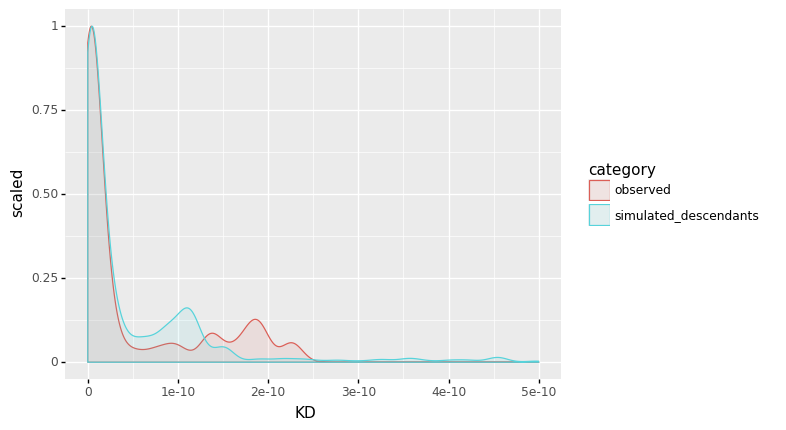

<ggplot: (8782599019039)>

In [17]:
cats = ["observed"] * len(mult_KDs)
cats.extend(["simulated_descendants"] * len(uniform_descendant_KDs))
uniform_all_KDs = mult_KDs + uniform_descendant_KDs
uniform_KD_df = pd.DataFrame({"KD": uniform_all_KDs, "category": cats})
print(f"Naive KD: {10 ** (-10.43)}")
print(f"Original KDs: mean {mean(mult_KDs)}, median {median(mult_KDs)}")
print(
    f"Descendant KDs: mean { mean(uniform_descendant_KDs)}, median {median(uniform_descendant_KDs)}"
)
(
    ggplot(uniform_KD_df, aes(x="KD", color="category", fill="category"))
    + geom_density(aes(y=after_stat("scaled")), alpha=0.1)
    + xlim(0, 0.5 * 10 ** (-9))
)